In [131]:
import pandas as pd
import re

trainDataset = pd.read_csv("C:/Users/ajjadhav/Downloads/NLP/Project_1_tools_and_data/dataset/MADAR-Corpus-26-train.tsv",
                           sep='.\t',
                          encoding ='utf-8-sig',
                          header=None)

<ipython-input-131-7e176b481127>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  trainDataset = pd.read_csv("C:/Users/ajjadhav/Downloads/NLP/Project_1_tools_and_data/dataset/MADAR-Corpus-26-train.tsv",


In [132]:
trainDataset.columns = ["Text","Label"]
trainDataset.head()

,Text,Label
0,هناك ، أمام بيانات السائح تماما,MSA
1,لم اسمع بهذا العنوان من قبل بالقرب من هنا,MSA
2,استمر في السير في هذا الطريق حتى تجد صيدلية,MSA
3,كم تكلفة الإفطار,MSA
4,كيف أستطيع مساعدتك,MSA


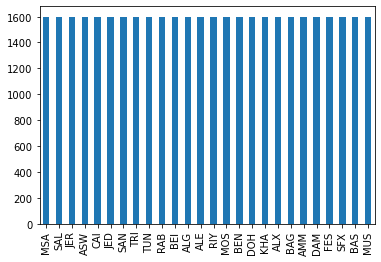

In [133]:
trainDataset.Label.value_counts().plot(kind='bar')

In [134]:
trainDataset.Text[0]

'هناك ، أمام بيانات السائح تماما '

In [135]:
trainDataset["Text"]= trainDataset["Text"].apply(lambda x: re.sub("https\S+"," ",x))

In [136]:
import camel_tools.tokenizers.word

trainDataset['TokenizeData']= trainDataset["Text"].apply(lambda x: camel_tools.tokenizers.word.simple_word_tokenize(x))

In [137]:
trainDataset["Text"] = trainDataset["Text"].apply(lambda x: x.lower())

In [138]:
trainDataset['TokenizeData'][0]

['هناك', '،', 'أمام', 'بيانات', 'السائح', 'تماما']

In [139]:
from nltk.corpus import stopwords
stopwordlist = set(stopwords.words('arabic'))
from nltk.stem.isri import ISRIStemmer
import unicodedata as ud

In [140]:
def preprocess_ar(text):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    st = ISRIStemmer()
    
    for t in text:
        t = ''.join(c for c in t if ud.category(c) == 'Lo' or ud.category(c) == 'Nd' or c == ' ')
        commentwords = ''
        for word in t.split():
            # Checking if the word is a stopword.
            if word not in stopwordlist :
                if len(word)>1:
                    # Lemmatizing the word.
                    word = st.suf32(word)
                    commentwords += (word+' ')
        processedText.append(commentwords)
    
    return processedText

In [141]:
text_ar = list(trainDataset["Text"])

trainDataset['ProcessedText'] = preprocess_ar(text_ar)


In [142]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainDataset['ProcessedText'], trainDataset['Label'], test_size = 0.02, random_state = 0)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vect=CountVectorizer()
X_train_counts=count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [143]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)
clf.fit(X_train_tfidf, y_train)

X_test_tfidf=count_vect.transform(X_test)

y_pred=clf.predict(X_test_tfidf)


from sklearn.metrics import confusion_matrix,accuracy_score
cm = confusion_matrix(y_test, y_pred)
Accuracy_Score = accuracy_score(y_test, y_pred)
print(Accuracy_Score)

0.13701923076923078


In [144]:
import gensim
from nltk import ngrams

from utilities import * # import utilities.py module
t_model = gensim.models.Word2Vec.load('C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl')

[2020-11-05 12:29:55,535 - INFO]: loading Word2Vec object from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl
[2020-11-05 12:29:55,543 - DEBUG]: {'uri': 'C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
[2020-11-05 12:30:00,179 - INFO]: loading wv recursively from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.wv.* with mmap=None
[2020-11-05 12:30:00,179 - INFO]: loading vectors from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.wv.vectors.npy with mmap=None
[2020-11-05 12:30:01,052 - INFO]: setting ignored attribute vectors_norm to None
[2020-11-05 12:30:01,058 - INFO]: loading vocabulary recursively from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.vocabulary.* with mma

In [293]:
import gensim
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer 
import string
from nltk.stem.isri import ISRIStemmer

In [299]:
arabic_punctuations = '''`÷×؛<>_()*&^%][،/:"؟.,'{}~¦+|!”…“–»«•'''
english_punctuations = string.punctuation
english_numbers = "0123456789"
punctuations_list = arabic_punctuations + english_punctuations + english_numbers


In [301]:
def normalize_arabic(text):
    text = re.sub("إ", "ا", text)
    text = re.sub("أ", "ا", text)
    text = re.sub("آ", "ا", text)
    text = re.sub("ا", "ا", text)
    #text = re.sub("ى", "ي", text)
    #text = re.sub("ؤ", "ء", text)
    #text = re.sub("ئ", "ء", text)
    #text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text



def remove_punctuations(text):
    for c in punctuations_list:
        text = text.replace(c," ")
    return text


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)
#----------------------------------------------------

#-------------tokenization and stop word removal
def tokens_remove_stopwords(text):

    text = text.split()
    result = list()
    ch = 0

    arabic_stop_words = ["من", "فى", "الي", "علي", "عن", "حتي", "مذ", "منذ", "و", "الا", "او", "ام", "ثم", "بل", "لكن",
                         "كل" , "متى" , "يوم"]

    for word in text:
        for stop_word in arabic_stop_words:
            if word == stop_word:
                ch = 1
                break

        if ch != 1:
            result.append(word)

        ch = 0

    return result
#_______________________________________

#Rooting words
def rooting(text):
    result = list()
    for word in text:
        stemmer = ISRIStemmer()
        result.append(stemmer.stem(word))
    return result

#remove english and empty strings
def remove_english(tokens):
    filtered_tokens = list()
    for word in tokens:
        if (not re.match(r'[a-zA-Z]+', word, re.I)) and word != '':
            filtered_tokens.append(word)
    return filtered_tokens


def preprocess1(text):
    text = str(text)
    text = remove_punctuations(text)
    text = normalize_arabic(text)
    text = remove_repeating_char(text)
    tokens = re.split(" ", text)
    tokens = remove_english(tokens)
    return tokens

def preprocess2(text):
    text = str(text)
    text = remove_punctuations(text)
    text = normalize_arabic(text)
    text = remove_repeating_char(text)
    text = tokens_remove_stopwords(text)
    text = remove_english(text)
    text = rooting(text)
    return text

def embed_doc(text,t_model):
    preprocessed_text = preprocess1(text)
    #print(preprocessed_text)
    
    embedded_vectors = np.zeros(shape=(100,100))#np array of arrays (array of 100/300 float number per word)
    embedded_vectors_index = 0
    for i in range(len(preprocessed_text)):
        try:
            embedded_vectors[embedded_vectors_index] = t_model.wv[preprocessed_text[i]]
            embedded_vectors_index = embedded_vectors_index + 1
        except:
            try:
                result = rooting([preprocessed_text[i]])[0]
                embedded_vectors[embedded_vectors_index] = t_model.wv[result]
                embedded_vectors_index = embedded_vectors_index + 1
            except:
                try:
                    #print("in google search " + preprocessed_text[i])
                    search_output = google_search(preprocessed_text[i])
                    #print("search_output " + search_output)
                    tokens = re.split(" ", search_output)
                    for j in range(len(tokens)):
                        try:
                            embedded_vectors[embedded_vectors_index] = t_model.wv[tokens[j]]
                            embedded_vectors_index = embedded_vectors_index + 1
                            print ("added " + tokens[j])
                        except:
                            print(tokens[j] + " Sub word cant be embedded")
                except:
                     print(preprocessed_text[i] + "word cant be embedded") #currently emojis can't be embedded and for any extreme case (skip wrongly written words)
    return embedded_vectors
  



def read_dataset():
    t_model = gensim.models.Word2Vec.load('C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl')
    
    X = trainDataset[['Text']].values
    Y = trainDataset[['Label']].values
    
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(Y) # need to be global or remembered to use it later
    one_hot_Y=label_binarizer.transform(Y)
    
    X_train, X_test, y_train, y_test = train_test_split(X,one_hot_Y, test_size = 0.3, random_state=42)
    
    eX_train = np.zeros(shape=(len(X_train),100,100))#number of tweets*max number of words per tweet*vector size per word
    eX_test = np.zeros(shape=(len(X_test),100,100))
    
    for i in range(len(X_train)):
        eX_train[i]= embed_doc(X_train[i],t_model)

    for i in range(len(X_test)):
        eX_test[i]= embed_doc(X_test[i],t_model)
        
    return eX_train, eX_test, y_train, y_test

                  
X_train, X_test, y_train, y_test = read_dataset()

[2020-11-05 15:06:06,150 - INFO]: loading Word2Vec object from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl
[2020-11-05 15:06:06,151 - DEBUG]: {'uri': 'C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl', 'mode': 'rb', 'buffering': -1, 'encoding': None, 'errors': None, 'newline': None, 'closefd': True, 'opener': None, 'ignore_ext': False, 'transport_params': None}
[2020-11-05 15:06:10,818 - INFO]: loading wv recursively from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.wv.* with mmap=None
[2020-11-05 15:06:10,820 - INFO]: loading vectors from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.wv.vectors.npy with mmap=None
[2020-11-05 15:06:11,031 - INFO]: setting ignored attribute vectors_norm to None
[2020-11-05 15:06:11,031 - INFO]: loading vocabulary recursively from C:/Users/ajjadhav/Downloads/full_grams_sg_100_wiki/full_grams_sg_100_wiki.mdl.vocabulary.* with mma

ستةword cant be embedded
الفئةword cant be embedded
اغيدword cant be embedded
كزاword cant be embedded
الىword cant be embedded
ستةword cant be embedded
مستشفىword cant be embedded
يبيعوword cant be embedded
بالملكةword cant be embedded
نقدروword cant be embedded
بزاطمword cant be embedded
تاليفونكword cant be embedded
الجايةword cant be embedded
رجاءاword cant be embedded
علىword cant be embedded
ثناشword cant be embedded
اغيدword cant be embedded
رجاءاword cant be embedded
شويةword cant be embedded
راحةword cant be embedded
علىword cant be embedded
لجنةword cant be embedded
واليموزينword cant be embedded
هتاكدword cant be embedded
الساعةword cant be embedded
شنوةword cant be embedded
علىword cant be embedded
بطاقةword cant be embedded
رجوword cant be embedded
تحركوword cant be embedded
نسقسيword cant be embedded
بصحword cant be embedded
حابword cant be embedded
لهيكword cant be embedded
لاسفword cant be embedded
اليلةword cant be embedded
بصحword cant be embedded
اىword cant be embed

دىword cant be embedded
محطةword cant be embedded
ترسمليword cant be embedded
كبوطword cant be embedded
بريطانيةword cant be embedded
علىword cant be embedded
هضاword cant be embedded
علىword cant be embedded
ابغىword cant be embedded
ترتبليword cant be embedded
كاسةword cant be embedded
هذولاword cant be embedded
حتىword cant be embedded
كنتمنىword cant be embedded
نعسword cant be embedded
بطاقةword cant be embedded
عطيتنيword cant be embedded
نائصينword cant be embedded
الىword cant be embedded
تنظفليword cant be embedded
المنوطوword cant be embedded
علىword cant be embedded
علىword cant be embedded
احكيليword cant be embedded
شويةword cant be embedded
منيحةword cant be embedded
شعندكword cant be embedded
شتقولword cant be embedded
يلقاوهword cant be embedded
الساعةword cant be embedded
مقشعرword cant be embedded
كولفword cant be embedded
معليشword cant be embedded
الساعةword cant be embedded
حتىword cant be embedded
بعدتئدword cant be embedded
بطريئةword cant be embedded
عالمطارword

كتعطيword cant be embedded
نوريهولكword cant be embedded
لائيword cant be embedded
الزوword cant be embedded
بمنطئةword cant be embedded
ماعندنشword cant be embedded
ارجىword cant be embedded
مبغيتشword cant be embedded
حاجةword cant be embedded
عدكمword cant be embedded
تنانword cant be embedded
وخمسميةword cant be embedded
بتاعتيword cant be embedded
نقدروword cant be embedded
اليمنىword cant be embedded
عتونوتوword cant be embedded
منيحword cant be embedded
علىword cant be embedded
هويةword cant be embedded
السفربيزبطword cant be embedded
حيطلعword cant be embedded
منصةword cant be embedded
تمانيةword cant be embedded
الىword cant be embedded
لمؤاخذةword cant be embedded
خلنيword cant be embedded
الكولواغword cant be embedded
كرهبتيword cant be embedded
هزهاليword cant be embedded
فمةword cant be embedded
علىword cant be embedded
الطائرةword cant be embedded
مزدحمةword cant be embedded
ستةword cant be embedded
غاحword cant be embedded
ابغىword cant be embedded
محطةword cant be embed

شويةword cant be embedded
كتعجبنيword cant be embedded
كتجيبword cant be embedded
استنىword cant be embedded
منشوفword cant be embedded
بريطانيةword cant be embedded
نشحنهword cant be embedded
منيحword cant be embedded
علىword cant be embedded
حتصلword cant be embedded
غاحword cant be embedded
دحينword cant be embedded
علىword cant be embedded
بالعادةword cant be embedded
بماليةword cant be embedded
منيحword cant be embedded
اشقدword cant be embedded
كيفاشword cant be embedded
حابword cant be embedded
صرلناword cant be embedded
مرةword cant be embedded
تعيطلناword cant be embedded
موضفينword cant be embedded
يتكلموword cant be embedded
بعتئدword cant be embedded
تحيةword cant be embedded
هاخدword cant be embedded
عهالخريطةword cant be embedded
حابword cant be embedded
كاثىword cant be embedded
دىword cant be embedded
دائريةword cant be embedded
شويةword cant be embedded
حطوword cant be embedded
عالطابقword cant be embedded
ماعمريشword cant be embedded
يحميواword cant be embedded
طاسةwo

كرةword cant be embedded
كيفاشword cant be embedded
فالكمنجةword cant be embedded
استنىword cant be embedded
ارجعلكword cant be embedded
كينبيword cant be embedded
تقولىword cant be embedded
دىword cant be embedded
علىword cant be embedded
مرةword cant be embedded
يمضوword cant be embedded
تصلحوword cant be embedded
رجاءاword cant be embedded
رجاءاword cant be embedded
ليساغword cant be embedded
ساعةword cant be embedded
الخدةword cant be embedded
علىword cant be embedded
اينشword cant be embedded
تعرفشword cant be embedded
مزدحمةword cant be embedded
المستشفىword cant be embedded
بدرىword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
الىword cant be embedded
متىword cant be embedded
بالقائمةword cant be embedded
احلىword cant be embedded
هالكلابword cant be embedded
دةword cant be embedded
علىword cant be embedded
رجاءًword cant be embedded
غاحword cant be embedded
هديكاword cant be embedded
مستعملتشword cant be embedded
واحداخرينword cant be embedded
ماعنديشwo

لغداword cant be embedded
علىword cant be embedded
علىword cant be embedded
كاتقلبword cant be embedded
علىword cant be embedded
حاجةword cant be embedded
اوكىword cant be embedded
اجيكword cant be embedded
ماكايناشword cant be embedded
حاجةword cant be embedded
تنطينيword cant be embedded
جطلword cant be embedded
نعيطword cant be embedded
تصبنليword cant be embedded
الىword cant be embedded
عطيتنيword cant be embedded
اوضتىword cant be embedded
ساقعةword cant be embedded
بوافقword cant be embedded
هالشيword cant be embedded
حجناword cant be embedded
عالساعةword cant be embedded
حدعشword cant be embedded
الساعةword cant be embedded
علىword cant be embedded
باليلةword cant be embedded
هالوقتword cant be embedded
لغالونword cant be embedded
بتسخنهword cant be embedded
بماكنةword cant be embedded
هضيword cant be embedded
محطةword cant be embedded
ندكword cant be embedded
فصعword cant be embedded
ساقوword cant be embedded
الجهةword cant be embedded
الساعةword cant be embedded
خذتword cant 

يبقىword cant be embedded
مصرياتيword cant be embedded
علىword cant be embedded
كيفاشword cant be embedded
ايحينword cant be embedded
اغيدword cant be embedded
علىword cant be embedded
علىword cant be embedded
اطناشرword cant be embedded
هديةword cant be embedded
اليلةword cant be embedded
علىword cant be embedded
الاصابةword cant be embedded
بنوبةword cant be embedded
ماكاينشword cant be embedded
ماكاتعجبنيشword cant be embedded
بتسوقword cant be embedded
الىword cant be embedded
كهديةword cant be embedded
موزيكةword cant be embedded
كانديروword cant be embedded
كليتوword cant be embedded
بتاعىword cant be embedded
الىword cant be embedded
لكومبوترword cant be embedded
سنةword cant be embedded
ازيدشword cant be embedded
هادوword cant be embedded
طلعتشword cant be embedded
علىword cant be embedded
يحكيوword cant be embedded
راشقينوword cant be embedded
قولولناword cant be embedded
السنةword cant be embedded
ماحجزتشword cant be embedded
ماعنديشword cant be embedded
اتمنىword cant be emb

الميزةword cant be embedded
حتسافرword cant be embedded
الطاكسيword cant be embedded
تلاثاword cant be embedded
هتدفعword cant be embedded
رجاءاword cant be embedded
الثنيةword cant be embedded
امتىword cant be embedded
لمدخنينword cant be embedded
هتدفعليword cant be embedded
علىword cant be embedded
ستةword cant be embedded
ابغاword cant be embedded
لازعاجكword cant be embedded
ازازةword cant be embedded
قداشword cant be embedded
شكثرword cant be embedded
علىword cant be embedded
الميزةword cant be embedded
علىword cant be embedded
علىword cant be embedded
اصريتوword cant be embedded
حنتفقword cant be embedded
الرقبةword cant be embedded
الكوفينوword cant be embedded
ترىword cant be embedded
حجربword cant be embedded
صنادقword cant be embedded
سرقليword cant be embedded
ابغىword cant be embedded
اغيدword cant be embedded
ايةword cant be embedded
مستشفىword cant be embedded
علىword cant be embedded
فىword cant be embedded
مكانشword cant be embedded
لسةword cant be embedded
تلاقىword c

فالطوبيسword cant be embedded
فالطيارةword cant be embedded
منيحword cant be embedded
منيحword cant be embedded
ادارةword cant be embedded
نهزكword cant be embedded
رجاءًword cant be embedded
علىword cant be embedded
يتلاقىword cant be embedded
علىword cant be embedded
مهمةword cant be embedded
ليساغword cant be embedded
شويةword cant be embedded
كيبيعword cant be embedded
صبعيword cant be embedded
نزعجكword cant be embedded
والطاكسيword cant be embedded
كوسيزword cant be embedded
تشيزبيرغرword cant be embedded
زحمةword cant be embedded
شنطتىword cant be embedded
الكرسىword cant be embedded
تخليهالىword cant be embedded
ابغاword cant be embedded
تليفونكword cant be embedded
داكشيword cant be embedded
خاصكword cant be embedded
وتبقىword cant be embedded
حتىword cant be embedded
ستةword cant be embedded
لفندقيword cant be embedded
تنقصليword cant be embedded
اينشword cant be embedded
ايحينword cant be embedded
حابword cant be embedded
علىword cant be embedded
التجاريةword cant be embedde

كلتلهword cant be embedded
تسعميةword cant be embedded
رجاءاword cant be embedded
مرةword cant be embedded
اثنىword cant be embedded
ادينىword cant be embedded
المطافىword cant be embedded
قوىword cant be embedded
دلوقتىword cant be embedded
هذوليword cant be embedded
حتشوفword cant be embedded
حيجيword cant be embedded
كدةword cant be embedded
امتىword cant be embedded
كنحسword cant be embedded
مخربقword cant be embedded
ترسمليword cant be embedded
مائةword cant be embedded
بالمائةword cant be embedded
كتديرword cant be embedded
غنيةword cant be embedded
صالصةword cant be embedded
شويةword cant be embedded
حاجةword cant be embedded
رفيجيword cant be embedded
علىword cant be embedded
بعضىword cant be embedded
الجايةword cant be embedded
دواعىword cant be embedded
سرورىword cant be embedded
انىword cant be embedded
بتاعتكword cant be embedded
وانىword cant be embedded
مهمةword cant be embedded
علىword cant be embedded
تجبدنيword cant be embedded
مابغيword cant be embedded
الساعةword can

صوباعىword cant be embedded
فىword cant be embedded
تزدانيword cant be embedded
باسبورتيword cant be embedded
استعملتشword cant be embedded
شويةword cant be embedded
المحطةword cant be embedded
مؤامرةword cant be embedded
كاتقبلword cant be embedded
حاجةword cant be embedded
هالورقةword cant be embedded
تسفword cant be embedded
ابقىword cant be embedded
اليلةword cant be embedded
نظفليword cant be embedded
الكبوطword cant be embedded
ابقىword cant be embedded
بتمنىword cant be embedded
تلقطوword cant be embedded
ازاىword cant be embedded
كصيرةword cant be embedded
هديةword cant be embedded
الىword cant be embedded
علىword cant be embedded
حاجةword cant be embedded
لضروراتيword cant be embedded
بظنword cant be embedded
بدوخةword cant be embedded
حابلغword cant be embedded
اكسواراتيword cant be embedded
اضافيةword cant be embedded
المبنىword cant be embedded
شويةword cant be embedded
كدةword cant be embedded
كدةword cant be embedded
كدةword cant be embedded
كدةword cant be embedded
علىwo

ستةword cant be embedded
لاسفword cant be embedded
هويةword cant be embedded
لفندقيword cant be embedded
ايةword cant be embedded
الىword cant be embedded
الاجراءاةword cant be embedded
قغيبword cant be embedded
هالسنةword cant be embedded
الخطةword cant be embedded
رجاءاًword cant be embedded
اربعطاشword cant be embedded
الىword cant be embedded
نحطواword cant be embedded
فىword cant be embedded
اىword cant be embedded
فىword cant be embedded
بصحword cant be embedded
غدوةword cant be embedded
علىword cant be embedded
علىword cant be embedded
باطوword cant be embedded
الساعةword cant be embedded
غاحword cant be embedded
ادوغword cant be embedded
رجاءاword cant be embedded
اتمنىword cant be embedded
القاعةword cant be embedded
يسرىword cant be embedded
اليمنىword cant be embedded
ائتمانيةword cant be embedded
طحتword cant be embedded
ياخدكword cant be embedded
هدولword cant be embedded
اعلىword cant be embedded
حوايجword cant be embedded
خمسمئةword cant be embedded
نحضرلكword cant be em

منيحword cant be embedded
ايحينword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
علىword cant be embedded
فالواقيعword cant be embedded
نجربوword cant be embedded
نحجزولكword cant be embedded
مرتاحةword cant be embedded
اتطيقword cant be embedded
سانتيمتراتword cant be embedded
لفةword cant be embedded
علىword cant be embedded
تحجزليword cant be embedded
بتختينword cant be embedded
علىword cant be embedded
خطةword cant be embedded
الساعةword cant be embedded
ايوةword cant be embedded
ضريفينword cant be embedded
اوكىword cant be embedded
علىword cant be embedded
علىword cant be embedded
تحبنىword cant be embedded
حبةword cant be embedded
صحيةword cant be embedded
حاجةword cant be embedded
مخصةword cant be embedded
بطاقةword cant be embedded
كاتسوىword cant be embedded
الاولىword cant be embedded
لايدنبرةword cant be embedded
هكاكةword cant be embedded
رجاءاword cant be embedded
قفشتينword cant be embedded
بم

خمسطعشword cant be embedded
عنوانكword cant be embedded
علىword cant be embedded
كنتوword cant be embedded
عدوغword cant be embedded
علىword cant be embedded
اغيدword cant be embedded
علىword cant be embedded
طماطword cant be embedded
الساعةword cant be embedded
خاصةword cant be embedded
تسوروتاروword cant be embedded
كاتاوكاword cant be embedded
السفيةword cant be embedded
قلولمword cant be embedded
غاحword cant be embedded
بالجيخانهword cant be embedded
خمسطعشرword cant be embedded
المحطةword cant be embedded
بهيكword cant be embedded
نبغىword cant be embedded
هادئةword cant be embedded
فىword cant be embedded
علىword cant be embedded
غاحword cant be embedded
انطيكword cant be embedded
فالتقاطعword cant be embedded
تظبطword cant be embedded
مرايةword cant be embedded
ساعةword cant be embedded
كانظنشword cant be embedded
حاحاولword cant be embedded
ضايلword cant be embedded
منيحword cant be embedded
نقدروword cant be embedded
نوفرولكword cant be embedded
هضاword cant be embedded
هادشي

بتيجيword cant be embedded
هتستمتعword cant be embedded
نلوجword cant be embedded
علىword cant be embedded
عتوقعword cant be embedded
علىword cant be embedded
ترسمليword cant be embedded
علىword cant be embedded
حابword cant be embedded
زحمةword cant be embedded
هدولword cant be embedded
شكثرword cant be embedded
اسميتوword cant be embedded
شوغيبوكوروword cant be embedded
شويةword cant be embedded
محطةword cant be embedded
ولتاكسىword cant be embedded
بتاعكword cant be embedded
علىword cant be embedded
تقربليword cant be embedded
معلشword cant be embedded
اسىword cant be embedded
الىword cant be embedded
فىword cant be embedded
دىword cant be embedded
قعمزword cant be embedded
استنىword cant be embedded
نرجعلكword cant be embedded
شويةword cant be embedded
تنقصليword cant be embedded
تضيقليword cant be embedded
الستفهword cant be embedded
هضيword cant be embedded
يغوحword cant be embedded
علىword cant be embedded
رمزورword cant be embedded
علىword cant be embedded
ستةword cant be embed

عالغداword cant be embedded
اتطيقword cant be embedded
حابينword cant be embedded
القائمةword cant be embedded
مرةword cant be embedded
ساعةword cant be embedded
عسانword cant be embedded
الساعةword cant be embedded
عنسافرword cant be embedded
المعدةword cant be embedded
الساعةword cant be embedded
بيغدword cant be embedded
اديشword cant be embedded
تسعميهword cant be embedded
الساعةword cant be embedded
اتعينواword cant be embedded
ميةword cant be embedded
ستةword cant be embedded
علىword cant be embedded
سنةword cant be embedded
الىword cant be embedded
ادينىword cant be embedded
صحيةword cant be embedded
فاضىword cant be embedded
دةword cant be embedded
اىword cant be embedded
حابword cant be embedded
مسمةword cant be embedded
سنةword cant be embedded
جايةword cant be embedded
بادوايزرword cant be embedded
علىword cant be embedded
نلقىword cant be embedded
نرنword cant be embedded
بصيغةword cant be embedded
اخرىword cant be embedded
يحصلوشword cant be embedded
مرةword cant be embedd

اتطيقword cant be embedded
بتاعىword cant be embedded
كرهبتيword cant be embedded
عوقتword cant be embedded
نقدملكword cant be embedded
نقدملهاword cant be embedded
تاجرليword cant be embedded
علىword cant be embedded
حندفعword cant be embedded
تنشحنword cant be embedded
اديشword cant be embedded
هالولدword cant be embedded
هويةword cant be embedded
خمسطعشرword cant be embedded
ماخديتشword cant be embedded
السنةword cant be embedded
الكرةword cant be embedded
ستةword cant be embedded
اثنينتلاثةword cant be embedded
ستةword cant be embedded
مجلةword cant be embedded
حاجةword cant be embedded
تشبهلهاword cant be embedded
الساعةword cant be embedded
هديةword cant be embedded
لمرتيword cant be embedded
بفيشword cant be embedded
خذيتword cant be embedded
المضطربةword cant be embedded
ابغىword cant be embedded
علىword cant be embedded
حكونword cant be embedded
الىword cant be embedded
امتىword cant be embedded
نغوحword cant be embedded
بواجباتكword cant be embedded
رجاءًword cant be embedded

دحينword cant be embedded
فحاخذهاword cant be embedded
حاجةword cant be embedded
رجاءاword cant be embedded
متىword cant be embedded
اشقدword cant be embedded
الساعةword cant be embedded
رجاءًword cant be embedded
محطةword cant be embedded
الجريهوندword cant be embedded
فىword cant be embedded
فىword cant be embedded
وشحالword cant be embedded
كيكلفword cant be embedded
عالتسعةword cant be embedded
الباقاجword cant be embedded
بوطيword cant be embedded
توةword cant be embedded
علىword cant be embedded
هالتاكسيword cant be embedded
قيتشword cant be embedded
رجاءاword cant be embedded
مادركتشword cant be embedded
لسةword cant be embedded
اوتاماتيكword cant be embedded
البتزاword cant be embedded
لذيذةword cant be embedded
شويةword cant be embedded
حابword cant be embedded
حتىword cant be embedded
علىword cant be embedded
ماكاتجاوبشword cant be embedded
كانصونيword cant be embedded
المحطةword cant be embedded
علىword cant be embedded
حجهزلكword cant be embedded
الاختياريةword cant be embe

مرتكword cant be embedded
اليلةword cant be embedded
الماضيةword cant be embedded
ستةword cant be embedded
حيمشيword cant be embedded
دسبوزبلword cant be embedded
عالتشيكword cant be embedded
هالايامword cant be embedded
يسلموword cant be embedded
حساسيةword cant be embedded
لبزازينword cant be embedded
الكميةword cant be embedded
بحطهاword cant be embedded
البلاستيكيةword cant be embedded
هضيناword cant be embedded
علىword cant be embedded
تغيدword cant be embedded
تغوحword cant be embedded
نتسوقword cant be embedded
الظهغword cant be embedded
هذمword cant be embedded
لاوضةword cant be embedded
مطلةword cant be embedded
علىword cant be embedded
فىword cant be embedded
اىword cant be embedded
اضافيةword cant be embedded
يبقىword cant be embedded
ميةword cant be embedded
هاخدword cant be embedded
عالشباكword cant be embedded
علىword cant be embedded
علىword cant be embedded
ابغاword cant be embedded
راحةword cant be embedded
الىword cant be embedded
رجاءاword cant be embedded
عادىword c

حارةword cant be embedded
حتىword cant be embedded
غالىword cant be embedded
شويةword cant be embedded
تدينىword cant be embedded
صيدليةword cant be embedded
ميمكنشword cant be embedded
المزبوطةword cant be embedded
حابword cant be embedded
نشوفهاword cant be embedded
المبنىword cant be embedded
الاشارةword cant be embedded
الجايةword cant be embedded
تنضمشword cant be embedded
القائمةword cant be embedded
مرةword cant be embedded
ميةword cant be embedded
بودوايزرword cant be embedded
المحطةword cant be embedded
وبطاقةword cant be embedded
رجاءاword cant be embedded
الطياغهword cant be embedded
الطاكسيword cant be embedded
خلينىword cant be embedded
محطةword cant be embedded
عندناشword cant be embedded
نحطهword cant be embedded
حطوword cant be embedded
اوكىword cant be embedded
الىword cant be embedded
الخاصةword cant be embedded
ياخذوشword cant be embedded
يتكيفوشword cant be embedded
هدولword cant be embedded
الطائرةword cant be embedded
متاخرةword cant be embedded
رجاءاword cant be 

بطاقةword cant be embedded
منيحword cant be embedded
اتغدىword cant be embedded
قهوةword cant be embedded
خاصكword cant be embedded
البزنسword cant be embedded
متىword cant be embedded
شنيةword cant be embedded
مخكword cant be embedded
الاستئبالword cant be embedded
مخذيتشword cant be embedded
نحتفلوword cant be embedded
هزنيword cant be embedded
اتمنىword cant be embedded
ميةword cant be embedded
بالميةword cant be embedded
ابغاword cant be embedded
بيمشيword cant be embedded
تلاثينword cant be embedded
الىword cant be embedded
باليلةword cant be embedded
فىword cant be embedded
علىword cant be embedded
عندكمشword cant be embedded
انريجمword cant be embedded
مهزوزةword cant be embedded
بنشوفكword cant be embedded
عمتنعرضword cant be embedded
خمستالافword cant be embedded
حتىword cant be embedded
بشحالword cant be embedded
ميةword cant be embedded
بلايصword cant be embedded
موصينword cant be embedded
كولشword cant be embedded
مزوعةword cant be embedded
تخيطليword cant be embedded
المدة

الساعةword cant be embedded
كرمالword cant be embedded
علىword cant be embedded
هذيجword cant be embedded
حجيبلكword cant be embedded
فىword cant be embedded
شويةword cant be embedded
سنةword cant be embedded
شباشword cant be embedded
الشباجword cant be embedded
واحداخرword cant be embedded
شويةword cant be embedded
ثنيةword cant be embedded
حيخليناword cant be embedded
يسوهword cant be embedded
نشوفهword cant be embedded
حابword cant be embedded
صنتيمword cant be embedded
بلايصword cant be embedded
اشحنword cant be embedded
فىword cant be embedded
كدةword cant be embedded
بالبلكونهword cant be embedded
شكبرword cant be embedded
الساعةword cant be embedded
خذتهword cant be embedded
هتورينيword cant be embedded
شويةword cant be embedded
كيفاشword cant be embedded
شايناطاونword cant be embedded
شقدword cant be embedded
حيدفعword cant be embedded
علىword cant be embedded
ويمانالوword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
تكلمليword cant be embedded
غدوةword

احكيليword cant be embedded
اغخصword cant be embedded
اجتيword cant be embedded
جهةword cant be embedded
علىword cant be embedded
الموضةword cant be embedded
دحينword cant be embedded
مرةword cant be embedded
ميزةword cant be embedded
تسوروتاروword cant be embedded
كاتاوكاword cant be embedded
عنديشword cant be embedded
البلايصword cant be embedded
منىword cant be embedded
محطةword cant be embedded
علىword cant be embedded
رجاءاword cant be embedded
مكنعتقدشword cant be embedded
نبقىword cant be embedded
مزدوجةword cant be embedded
ينعنword cant be embedded
ينعنword cant be embedded
ينعنword cant be embedded
ينعنword cant be embedded
علىword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
العنةword cant be embedded
علىword cant be embedded
البخشيشword cant be embedded
ميةword cant be embedded
وقتاشword cant be embedded
رجاءاword cant be embedded
شمخword cant be embedded
الخمسطعشword cant be embedded
يوخذوword cant be embedded
كدةword ca

بريطانيةword cant be embedded
كدةword cant be embedded
اشلword cant be embedded
ضايلword cant be embedded
رجاءًword cant be embedded
مرتكword cant be embedded
اغيدword cant be embedded
الهديةword cant be embedded
كيفاشword cant be embedded
الكرهبةword cant be embedded
وقفتليword cant be embedded
علىword cant be embedded
شويةword cant be embedded
كايقولوword cant be embedded
نصيفطوword cant be embedded
فغاسword cant be embedded
معلشword cant be embedded
علىword cant be embedded
وقتاشword cant be embedded
المعدةword cant be embedded
بطاقةword cant be embedded
امشىword cant be embedded
علىword cant be embedded
اشارةword cant be embedded
رجاءًword cant be embedded
انبطحword cant be embedded
المحطةword cant be embedded
البشكليطهword cant be embedded
قداشword cant be embedded
نبقىword cant be embedded
اخرىword cant be embedded
توقعلىword cant be embedded
وامضيهword cant be embedded
شويةword cant be embedded
ايوةword cant be embedded
كيفاشword cant be embedded
مرةword cant be embedded
لمكانكw

علىword cant be embedded
حاجةword cant be embedded
عايزتوضحهاword cant be embedded
غاتمشيword cant be embedded
امتىword cant be embedded
عمطعمword cant be embedded
عمرهادword cant be embedded
علىword cant be embedded
حرامىword cant be embedded
صجword cant be embedded
بيروحword cant be embedded
رجاءًword cant be embedded
لسةword cant be embedded
علىword cant be embedded
اؤجرword cant be embedded
حتىword cant be embedded
كانتمنىword cant be embedded
اجازةword cant be embedded
علىword cant be embedded
ابغىword cant be embedded
هالغرفةword cant be embedded
نحكيوword cant be embedded
قهوةword cant be embedded
تخلصوword cant be embedded
لباركينغword cant be embedded
بالزبطword cant be embedded
المبنىword cant be embedded
حتىword cant be embedded
الاشارةword cant be embedded
تلثميةword cant be embedded
معلشword cant be embedded
قلتوword cant be embedded
هلئword cant be embedded
الصجword cant be embedded
ندخنword cant be embedded
تليفونكword cant be embedded
حالةword cant be embedded
كتقصدword

رجاءاword cant be embedded
حنديرword cant be embedded
البقشيشword cant be embedded
نهزword cant be embedded
هاذوماword cant be embedded
جاكتword cant be embedded
عالكرسيword cant be embedded
الساعةword cant be embedded
غنيةword cant be embedded
مخدةword cant be embedded
بعتذرword cant be embedded
تحكيليword cant be embedded
بشوفتكword cant be embedded
ابغاword cant be embedded
علشانكword cant be embedded
يصيفطوword cant be embedded
اضافيةword cant be embedded
علىword cant be embedded
الريسيلword cant be embedded
اغيدword cant be embedded
الاضيفغword cant be embedded
نبقىword cant be embedded
حتىword cant be embedded
الميةword cant be embedded
طبيةword cant be embedded
هالعربةword cant be embedded
اخرىword cant be embedded
الطرانword cant be embedded
ازاىword cant be embedded
ديزنىword cant be embedded
بلايصword cant be embedded
شيكاقوword cant be embedded
اليلةword cant be embedded
الماضيةword cant be embedded
فىword cant be embedded
صينىword cant be embedded
كبوطword cant be embedded


ساعةword cant be embedded
كهوword cant be embedded
علىword cant be embedded
محطةword cant be embedded
الامانةword cant be embedded
لبخشيشword cant be embedded
الساعةword cant be embedded
الجايةword cant be embedded
ستةword cant be embedded
الجويةword cant be embedded
المرجانيةword cant be embedded
متهياليword cant be embedded
ميةword cant be embedded
ستةword cant be embedded
شويةword cant be embedded
يابانىword cant be embedded
عالشاطيword cant be embedded
خاصكword cant be embedded
لئلكword cant be embedded
لموسطاشword cant be embedded
بطاريةword cant be embedded
رجاءاword cant be embedded
راهوword cant be embedded
ساعةword cant be embedded
تطعيماتكword cant be embedded
نحجزلكword cant be embedded
علىword cant be embedded
كولفword cant be embedded
كبوطword cant be embedded
حطيتوword cant be embedded
علىword cant be embedded
هالطريقword cant be embedded
القهوةword cant be embedded
شنكهاword cant be embedded
وقتاشword cant be embedded
اخرىword cant be embedded
عيجينword cant be embedded


جنطتيword cant be embedded
شويةword cant be embedded
معلشword cant be embedded
فىword cant be embedded
حوالىword cant be embedded
لشيخوخةword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
نستريحword cant be embedded
مستشفىword cant be embedded
باخذكword cant be embedded
اخرىword cant be embedded
اخرىword cant be embedded
فنيةword cant be embedded
توةword cant be embedded
متاسفword cant be embedded
ماكينشword cant be embedded
الصحةword cant be embedded
حتىword cant be embedded
صحةword cant be embedded
بطاقةword cant be embedded
ترايبودword cant be embedded
متىword cant be embedded
حنوصلword cant be embedded
نديكword cant be embedded
لمكانكword cant be embedded
البوردنجword cant be embedded
نستنىword cant be embedded
المضلةword cant be embedded
نعيطword cant be embedded
لخاريجword cant be embedded
الىword cant be embedded
ميكىword cant be embedded
دىword cant be embedded
تبغىword cant be embedded
تقصروword cant be embedded
علىword cant be embedded
هكاword cant be 

محطةword cant be embedded
الساعةword cant be embedded
ديسيرword cant be embedded
غاحword cant be embedded
هساword cant be embedded
لانتباهكword cant be embedded
علىword cant be embedded
ضهرليword cant be embedded
تقدرشword cant be embedded
علىword cant be embedded
هادوword cant be embedded
رائعةword cant be embedded
علىword cant be embedded
بعمغword cant be embedded
خمسطعشword cant be embedded
علىword cant be embedded
جافةword cant be embedded
هادشيword cant be embedded
لقيتوword cant be embedded
علىword cant be embedded
عالمنتزهword cant be embedded
علىword cant be embedded
الجويةword cant be embedded
دركسيونword cant be embedded
تقدرتخيطهاword cant be embedded
رجاءاword cant be embedded
وقعمword cant be embedded
الاختياريةword cant be embedded
شسword cant be embedded
حوايجناword cant be embedded
الطوبيسword cant be embedded
كولشword cant be embedded
هضاword cant be embedded
اعادةword cant be embedded
ماشيةword cant be embedded
علىword cant be embedded
اقصىword cant be embedded
تكصرwo

طبيةword cant be embedded
علىword cant be embedded
علىword cant be embedded
علىword cant be embedded
الجويةword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
لاسفword cant be embedded
جزدانيword cant be embedded
هالبيتزاword cant be embedded
علىword cant be embedded
علىword cant be embedded
ابغىword cant be embedded
ساعةword cant be embedded
نلقىword cant be embedded
بركرword cant be embedded
رجاءاword cant be embedded
الصحةword cant be embedded
مكغيرword cant be embedded
بقداشword cant be embedded
حيدفعword cant be embedded
علىword cant be embedded
كولشword cant be embedded
غاحword cant be embedded
اجيكword cant be embedded
المغبword cant be embedded
هضيword cant be embedded
شويةword cant be embedded
خصوword cant be embedded
عيطword cant be embedded
اليلةword cant be embedded
الجنطword cant be embedded
الساعةword cant be embedded
قدلكword cant be embedded
نقترحوword cant be embedded
علىword cant be embedded
غاحword cant be embedded
المحطةword cant be embedded
ا

ثنينword cant be embedded
زحمةword cant be embedded
باربعتشword cant be embedded
فىword cant be embedded
اىword cant be embedded
حتىword cant be embedded
هضكيword cant be embedded
متخربطword cant be embedded
الساعةword cant be embedded
مستشفىword cant be embedded
علىword cant be embedded
هالقدword cant be embedded
صلحوword cant be embedded
اجتword cant be embedded
ميةword cant be embedded
نعاونكword cant be embedded
حيجيword cant be embedded
حاجةword cant be embedded
هضيword cant be embedded
يمتىword cant be embedded
حتىword cant be embedded
اتمنىword cant be embedded
امحتىword cant be embedded
كدةword cant be embedded
محفظتىword cant be embedded
هفضلword cant be embedded
هبقىword cant be embedded
قولتلهword cant be embedded
تنجمشيword cant be embedded
شوبينجword cant be embedded
بطاقةword cant be embedded
وقتاشword cant be embedded
مخرword cant be embedded
وكعتword cant be embedded
الجطلword cant be embedded
بليةword cant be embedded
زحمةword cant be embedded
جزدانيword cant be embedd

بلايصword cant be embedded
عالطابقword cant be embedded
طبيةword cant be embedded
اعملتوword cant be embedded
شهغword cant be embedded
الىword cant be embedded
ايدنبيرهword cant be embedded
حتدفعليword cant be embedded
شويةword cant be embedded
الساعةword cant be embedded
ستةword cant be embedded
المحطةword cant be embedded
علىword cant be embedded
لبلايصword cant be embedded
متاسفword cant be embedded
القائمةword cant be embedded
اليلةword cant be embedded
دميةword cant be embedded
صيفطوword cant be embedded
اطلطاشword cant be embedded
كنتشword cant be embedded
هذلاword cant be embedded
هالشرابword cant be embedded
مكيهمشword cant be embedded
علىword cant be embedded
نلقاهاword cant be embedded
عاليسارword cant be embedded
توةword cant be embedded
احسنلكword cant be embedded
نقدرشword cant be embedded
الشاشةword cant be embedded
شويةword cant be embedded
نتمنىword cant be embedded
ماتكونشword cant be embedded
مكوةword cant be embedded
مويةword cant be embedded
مخطword cant be embedded

منيحword cant be embedded
ايوةword cant be embedded
ترسمليword cant be embedded
مخطword cant be embedded
علىword cant be embedded
سطوشword cant be embedded
ميةword cant be embedded
دلارword cant be embedded
كيصلحword cant be embedded
مكجوايرword cant be embedded
الفوتبولword cant be embedded
حتىword cant be embedded
محطةword cant be embedded
الطوبيسword cant be embedded
معفاةword cant be embedded
الىword cant be embedded
دلوقتىword cant be embedded
لشيخوخةword cant be embedded
ندقword cant be embedded
صلحليword cant be embedded
شويةword cant be embedded
رجاءًword cant be embedded
معليشword cant be embedded
كثيغword cant be embedded
ميةword cant be embedded
الميةword cant be embedded
اوىword cant be embedded
فىword cant be embedded
الالمانىword cant be embedded
والامتعةword cant be embedded
الاخرىword cant be embedded
اخرىword cant be embedded
منيحword cant be embedded
بتوقيتكword cant be embedded
كدةword cant be embedded
بتظنword cant be embedded
فخزنةword cant be embedded
النهاردةword

كتظنword cant be embedded
هادشيword cant be embedded
تمانيةword cant be embedded
ياماجوتشيword cant be embedded
علىword cant be embedded
ايجبولنةword cant be embedded
بطاريةword cant be embedded
علىword cant be embedded
نعرفشword cant be embedded
حنجربword cant be embedded
علىword cant be embedded
وارحword cant be embedded
علىword cant be embedded
اربعطعشword cant be embedded
طبيةword cant be embedded
حكماتوword cant be embedded
هضاword cant be embedded
علىword cant be embedded
الىword cant be embedded
المحطةword cant be embedded
علىword cant be embedded
بناخذهword cant be embedded
مزحةword cant be embedded
اخسنword cant be embedded
بيطلعوword cant be embedded
بتختينword cant be embedded
نسجمword cant be embedded
جزدانيword cant be embedded
اختفىword cant be embedded
رجاءاword cant be embedded
ماهياشword cant be embedded
تدوزليword cant be embedded
الملحةword cant be embedded
تجيكword cant be embedded
عنجدword cant be embedded
بتحبوword cant be embedded
متىword cant be embedded
شويةwor

علىword cant be embedded
كثيغword cant be embedded
علىword cant be embedded
كيخليword cant be embedded
هديةword cant be embedded
كنقدرword cant be embedded
الموسيقىword cant be embedded
الكلاسيكيةword cant be embedded
علىword cant be embedded
باحصلازمword cant be embedded
حتىword cant be embedded
الشاشةword cant be embedded
هالمنظرword cant be embedded
هالطرقاتword cant be embedded
بتجنword cant be embedded
منظفةword cant be embedded
علىword cant be embedded
فالتقاطعword cant be embedded
حابword cant be embedded
وقتاشword cant be embedded
ازيكword cant be embedded
علىword cant be embedded
شويةword cant be embedded
علىword cant be embedded
عهاوايword cant be embedded
كنزورالبحيراتword cant be embedded
الكبرىword cant be embedded
مرةword cant be embedded
الزنقةword cant be embedded
الكافيتيرياword cant be embedded
علىword cant be embedded
فالحافلةword cant be embedded
فالطيارةword cant be embedded
جمبرىword cant be embedded
الحاجةword cant be embedded
فكةword cant be embedded
الباركنقwor

نبقىword cant be embedded
حتىword cant be embedded
حاجةword cant be embedded
اقربائناword cant be embedded
اتزحلقword cant be embedded
فىword cant be embedded
علىword cant be embedded
مانقدرشword cant be embedded
هضاword cant be embedded
لالعمالقةword cant be embedded
اخرىword cant be embedded
دىword cant be embedded
مثاليةword cant be embedded
ادزword cant be embedded
نارىword cant be embedded
غوحword cant be embedded
ليساغword cant be embedded
عنقدرword cant be embedded
بتاعيword cant be embedded
ستةword cant be embedded
بالشامبانياword cant be embedded
بصحتكword cant be embedded
اتغيرword cant be embedded
دةword cant be embedded
شويةword cant be embedded
اصطناعيةword cant be embedded
علىword cant be embedded
بميةword cant be embedded
علىword cant be embedded
رجاءًword cant be embedded
علىword cant be embedded
عالساعةword cant be embedded
صالصهword cant be embedded
خاصةword cant be embedded
احسنلكword cant be embedded
عالميلword cant be embedded
حاجةword cant be embedded
شويةword can

رجاءاword cant be embedded
قذلتيword cant be embedded
علىword cant be embedded
القىword cant be embedded
خلناword cant be embedded
كيفاشword cant be embedded
حارةword cant be embedded
وايمالنالوword cant be embedded
مكاينشword cant be embedded
بهالقياسword cant be embedded
منيحword cant be embedded
يتكلموword cant be embedded
تقدروword cant be embedded
تشخيركword cant be embedded
هالمحلword cant be embedded
الخيرلوقتكword cant be embedded
بظنword cant be embedded
تقدرشword cant be embedded
رجاءًword cant be embedded
ستةword cant be embedded
ابغىword cant be embedded
الساعةword cant be embedded
معفيةword cant be embedded
كيرلىword cant be embedded
جزدانword cant be embedded
ميةword cant be embedded
علىword cant be embedded
اليلةword cant be embedded
متاخرةword cant be embedded
شويةword cant be embedded
اتزحلقword cant be embedded
هادوword cant be embedded
تلقىword cant be embedded
هالشنتايةword cant be embedded
شويةword cant be embedded
يتظبطword cant be embedded
الساعةword cant be embe

كاعدword cant be embedded
خليتوهاword cant be embedded
بجنطتيword cant be embedded
مجلةword cant be embedded
ابغاword cant be embedded
اىword cant be embedded
لساword cant be embedded
مانكونوشword cant be embedded
شقدword cant be embedded
سيداتىword cant be embedded
وسادتىword cant be embedded
فىword cant be embedded
النهاردةword cant be embedded
يابانىword cant be embedded
والىword cant be embedded
الىword cant be embedded
اىword cant be embedded
فىword cant be embedded
الحوايجword cant be embedded
نظافword cant be embedded
دواعىword cant be embedded
نقدملكword cant be embedded
الىword cant be embedded
فىword cant be embedded
دىword cant be embedded
فىword cant be embedded
المجلةword cant be embedded
بتاعتناword cant be embedded
اليلةword cant be embedded
الرائعةword cant be embedded
ميسالشword cant be embedded
تفسرليword cant be embedded
مظلword cant be embedded
اطفيword cant be embedded
هالضوword cant be embedded
غامئword cant be embedded
بتاعيword cant be embedded
مخطword cant be e

نحجزلكword cant be embedded
حتىword cant be embedded
سرقوليword cant be embedded
بطاقةword cant be embedded
ائتمانيةword cant be embedded
المشاريبword cant be embedded
بتاعتهword cant be embedded
متىword cant be embedded
يلاقوهword cant be embedded
عالطيارةword cant be embedded
سنةword cant be embedded
ديقوword cant be embedded
بطاريةword cant be embedded
الجويةword cant be embedded
رجاءاword cant be embedded
نتلاقاوword cant be embedded
علىword cant be embedded
هالخريطةword cant be embedded
مانعرفشword cant be embedded
محطةword cant be embedded
مئةword cant be embedded
الجويةword cant be embedded
حتمطرword cant be embedded
هالحوتword cant be embedded
علىword cant be embedded
بشتغلword cant be embedded
هدولword cant be embedded
ستةword cant be embedded
بياخدword cant be embedded
وعلاشword cant be embedded
متهديلوشword cant be embedded
هديةword cant be embedded
القهوةword cant be embedded
امتىword cant be embedded
حيجيword cant be embedded
الصوابعword cant be embedded
نشوفكword cant be 

لدةword cant be embedded
عطاوكword cant be embedded
تمانيةword cant be embedded
اليةword cant be embedded
هضاword cant be embedded
اتزلجword cant be embedded
عاليسارword cant be embedded
وايمنالوword cant be embedded
لمدخنينword cant be embedded
فالمؤخرةword cant be embedded
ساعةword cant be embedded
غديشword cant be embedded
غتديرword cant be embedded
ساعةword cant be embedded
لموسيقىword cant be embedded
تسجيلاتيword cant be embedded
برضةword cant be embedded
محطةword cant be embedded
جرايهاوندword cant be embedded
يشكروword cant be embedded
يدعموword cant be embedded
الكترونوكword cant be embedded
نضلword cant be embedded
علىword cant be embedded
بلايصword cant be embedded
الجويةword cant be embedded
راحةword cant be embedded
هكاword cant be embedded
تمرقليword cant be embedded
حابword cant be embedded
احبوword cant be embedded
تنوضنيword cant be embedded
علىword cant be embedded
الستةword cant be embedded
مخذيناشword cant be embedded
خمسميةword cant be embedded
بطىword cant be embe

ستةword cant be embedded
ستةword cant be embedded
متىword cant be embedded
تبردوword cant be embedded
البنةword cant be embedded
فىword cant be embedded
دةword cant be embedded
بطاقةword cant be embedded
ستةword cant be embedded
علىword cant be embedded
نروحواword cant be embedded
فالحافلةword cant be embedded
حارةword cant be embedded
بالشامبانياword cant be embedded
لصحتكword cant be embedded
مجلةword cant be embedded
علىword cant be embedded
اثنعشword cant be embedded
هاعرفword cant be embedded
امتىword cant be embedded
شويةword cant be embedded
غاحword cant be embedded
رجاءاword cant be embedded
متاسفword cant be embedded
البطاقةword cant be embedded
جوازكword cant be embedded
حتضركword cant be embedded
محطةword cant be embedded
دةword cant be embedded
هالبرنامجword cant be embedded
القىword cant be embedded
ساعةword cant be embedded
منبيعوشword cant be embedded
تخينهword cant be embedded
زىword cant be embedded
تاخدهword cant be embedded
مرةword cant be embedded
فىword cant be emb

الساعةword cant be embedded
تئليword cant be embedded
حتىword cant be embedded
الساعةword cant be embedded
امتىword cant be embedded
ماكانشword cant be embedded
نقدروword cant be embedded
نروحوword cant be embedded
نبغىword cant be embedded
غوحword cant be embedded
رجاءاword cant be embedded
بتاعتيword cant be embedded
العائلةword cant be embedded
علىword cant be embedded
الجويةword cant be embedded
الاخرىword cant be embedded
علىword cant be embedded
زويةword cant be embedded
علىword cant be embedded
متاسفword cant be embedded
تحكيليword cant be embedded
مهمةword cant be embedded
لكتفضلword cant be embedded
تغيرلىword cant be embedded
نقدروword cant be embedded
تانىword cant be embedded
شويةword cant be embedded
علىword cant be embedded
فيكاسword cant be embedded
عالساعةword cant be embedded
خمسميةword cant be embedded
وتلاثةword cant be embedded
رجاءًword cant be embedded
منيحword cant be embedded
عيصيغword cant be embedded
كمتاخرword cant be embedded
مخربطword cant be embedded
خمسطع

بتختينword cant be embedded
علىword cant be embedded
بالتسعميةword cant be embedded
علىword cant be embedded
رجاءاword cant be embedded
صنوقword cant be embedded
عندىword cant be embedded
مخطword cant be embedded
مؤاخذةword cant be embedded
بتاعيword cant be embedded
دئيئةword cant be embedded
تقدرشword cant be embedded
حاجةword cant be embedded
حالةword cant be embedded
شويةword cant be embedded
بطاقتكword cant be embedded
ازاىword cant be embedded
بتخلىword cant be embedded
الطوبيسword cant be embedded
مانشوفword cant be embedded
فالنواحيword cant be embedded
هامبرجرword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
اخرىword cant be embedded
دةword cant be embedded
جهةword cant be embedded
اتغيدword cant be embedded
علىword cant be embedded
حوايجword cant be embedded
الساعةword cant be embedded
ستةword cant be embedded
هالمقاسword cant be embedded
متىword cant be embedded
منجمشword cant be embedded
يتهجىword cant be embedded
بئدمword cant be embedded
ترويئةwor

لفندقيword cant be embedded
بقهوةword cant be embedded
رجاءاword cant be embedded
لجنةword cant be embedded
اليموزينword cant be embedded
الساعةword cant be embedded
عدىword cant be embedded
علىword cant be embedded
حتىword cant be embedded
مخدةword cant be embedded
حابword cant be embedded
ساعةword cant be embedded
علىword cant be embedded
اربعمئةword cant be embedded
القهوةword cant be embedded
العشيةword cant be embedded
الساعةword cant be embedded
علىword cant be embedded
علىword cant be embedded
وعدتوword cant be embedded
غاحword cant be embedded
متاسفword cant be embedded
لانىword cant be embedded
ازعجتكword cant be embedded
ابغىword cant be embedded
بطاريةword cant be embedded
ايةword cant be embedded
صلحهوليword cant be embedded
بدلهوليword cant be embedded
نضيفةword cant be embedded
الساعةword cant be embedded
باخدوword cant be embedded
احسنلكword cant be embedded
تزبطword cant be embedded
ابئاword cant be embedded
هالبنايةword cant be embedded
علىword cant be embedded
الباركي

تدزليword cant be embedded
بدويايزرword cant be embedded
رجاءًword cant be embedded
تقضرword cant be embedded
لكارنيجيword cant be embedded
يبفعword cant be embedded
ابتعword cant be embedded
الخطةword cant be embedded
بشوفword cant be embedded
استنىword cant be embedded
سنةword cant be embedded
توقيعشword cant be embedded
احسنلكword cant be embedded
تظبطword cant be embedded
المرايةword cant be embedded
مكانشword cant be embedded
علىword cant be embedded
بلاقيword cant be embedded
احكيليword cant be embedded
صيدليةword cant be embedded
المحطةword cant be embedded
هضاword cant be embedded
علىword cant be embedded
الجهةword cant be embedded
ابغىword cant be embedded
حطيتوword cant be embedded
علىword cant be embedded
هديةword cant be embedded
جزدانword cant be embedded
رجاءاword cant be embedded
رجاءًword cant be embedded
الىword cant be embedded
فىword cant be embedded
عدةword cant be embedded
السميةword cant be embedded
ستةword cant be embedded
واربعمائةword cant be embedded
بالفانيلي

شكثرword cant be embedded
بياخذword cant be embedded
علىword cant be embedded
الميزةword cant be embedded
اتاخرتword cant be embedded
اشلهword cant be embedded
بتنعطاword cant be embedded
شويةword cant be embedded
بتحكوword cant be embedded
علىword cant be embedded
غاحword cant be embedded
لدريword cant be embedded
البمشيword cant be embedded
كيوتوايكيword cant be embedded
اشارةword cant be embedded
وقتاشword cant be embedded
جوكلتword cant be embedded
حتىword cant be embedded
الانقليزيةword cant be embedded
ياخدهword cant be embedded
الحلاءword cant be embedded
نلقىword cant be embedded
بتستنىword cant be embedded
مشطشطword cant be embedded
كمامword cant be embedded
اخرىword cant be embedded
علىword cant be embedded
المعدةword cant be embedded
البلكونةword cant be embedded
دلوقتىword cant be embedded
منيحword cant be embedded
ايحينword cant be embedded
عيوقعword cant be embedded
بوعكةword cant be embedded
علىword cant be embedded
لمراتيword cant be embedded
فكةword cant be embedded
عل

الكولفword cant be embedded
غامقةword cant be embedded
الىword cant be embedded
علىword cant be embedded
رائعةword cant be embedded
نشوفكword cant be embedded
مرةword cant be embedded
مباشرةودورword cant be embedded
علىword cant be embedded
علىword cant be embedded
محطةword cant be embedded
عمقعدكword cant be embedded
امتىword cant be embedded
ابغىword cant be embedded
علىword cant be embedded
شوجيبوكوروword cant be embedded
حتىword cant be embedded
صيدليةword cant be embedded
هضكيword cant be embedded
الكالامارword cant be embedded
علىword cant be embedded
علىword cant be embedded
اشترىword cant be embedded
الاىword cant be embedded
دةword cant be embedded
هالطباخةword cant be embedded
مرتكword cant be embedded
هويةword cant be embedded
علىword cant be embedded
بحذاكword cant be embedded
نلقىword cant be embedded
مرةword cant be embedded
اليلةword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
امتىword cant be embedded
كيكلفword cant be embedded
حاجةword cant be

نحطword cant be embedded
القىword cant be embedded
بوركرword cant be embedded
غوحهword cant be embedded
مكاتغلضشword cant be embedded
فىword cant be embedded
الجويةword cant be embedded
انىword cant be embedded
بيمشيword cant be embedded
غاحword cant be embedded
كبيغword cant be embedded
ابيخword cant be embedded
علىword cant be embedded
الكريةword cant be embedded
الوحةword cant be embedded
شويغبكword cant be embedded
رجاءاword cant be embedded
تغيدword cant be embedded
اكثغword cant be embedded
الساعةword cant be embedded
كثيغword cant be embedded
حاغهword cant be embedded
علىword cant be embedded
نعاونوهword cant be embedded
قولولناword cant be embedded
علىword cant be embedded
الساعةword cant be embedded
غاحword cant be embedded
حتىword cant be embedded
حاكلمهاword cant be embedded
المستشفىword cant be embedded
ايوةword cant be embedded
الساعةword cant be embedded
علىword cant be embedded
منيحword cant be embedded
الجويةword cant be embedded
هديةword cant be embedded
الىword cant b

متشغشهword cant be embedded
الىword cant be embedded
متىword cant be embedded
حتىword cant be embedded
شويةword cant be embedded
رداءاword cant be embedded
حوايجword cant be embedded
بتفضلوword cant be embedded
شويةword cant be embedded
بوظةword cant be embedded
علىword cant be embedded
اثنعشword cant be embedded
نادىword cant be embedded
علىword cant be embedded
عالجبالword cant be embedded
علىword cant be embedded
احلىword cant be embedded
الرئيسىword cant be embedded
مشىword cant be embedded
طفيةword cant be embedded
دسجائرword cant be embedded
الاضافةword cant be embedded
اولىword cant be embedded
الىword cant be embedded
الىword cant be embedded
هالطبقword cant be embedded
تحكيلهword cant be embedded
حابword cant be embedded
بهكيword cant be embedded
الصيقةword cant be embedded
دىword cant be embedded
ستةword cant be embedded
دحينword cant be embedded
هديةword cant be embedded
شنحوالكword cant be embedded
السنةword cant be embedded
الخاصةword cant be embedded
علىword cant be embed

بتاعتىword cant be embedded
انىword cant be embedded
اوىword cant be embedded
دلوقتىword cant be embedded
ازازةword cant be embedded
دةword cant be embedded
ماكنشword cant be embedded
حنرجعword cant be embedded
اشارةword cant be embedded
شريتوword cant be embedded
علىword cant be embedded
الامانةword cant be embedded
المثلىword cant be embedded
علىword cant be embedded
عنوانكword cant be embedded
قهوةword cant be embedded
بضاينword cant be embedded
شويةword cant be embedded
هالفستانword cant be embedded
مزقةword cant be embedded
بتاعتيword cant be embedded
علىword cant be embedded
الميةword cant be embedded
حشتريword cant be embedded
امتىword cant be embedded
حيوصلword cant be embedded
اكبغword cant be embedded
يجيبولنهword cant be embedded
ماظنشword cant be embedded
حتىword cant be embedded
متىword cant be embedded
طبيةword cant be embedded
رجاءًword cant be embedded
طوبيسword cant be embedded
كايمشيword cant be embedded
محطةword cant be embedded
بالصحword cant be embedded
كيفاشword c

شويةword cant be embedded
مرايةword cant be embedded
امشىword cant be embedded
علىword cant be embedded
ابغاword cant be embedded
المدىword cant be embedded
الىword cant be embedded
الىword cant be embedded
القاعةword cant be embedded
علىword cant be embedded
نشتيword cant be embedded
المبنىword cant be embedded
اشارةword cant be embedded
كيوصلword cant be embedded
الطرانword cant be embedded
بشحالword cant be embedded
حتالword cant be embedded
منيحword cant be embedded
متنوعهاword cant be embedded
ماشىword cant be embedded
اوخيكword cant be embedded
قهوةword cant be embedded
مرةword cant be embedded
قداشword cant be embedded
علىword cant be embedded
بوافقكword cant be embedded
عجبنيشword cant be embedded
شويةword cant be embedded
قداشword cant be embedded
عاليسارword cant be embedded
بهالشارعword cant be embedded
عاليمينword cant be embedded
علىword cant be embedded
هضيناword cant be embedded
علىword cant be embedded
قداشword cant be embedded
متديشword cant be embedded
بقشيشword cant 

متهياليword cant be embedded
كدةword cant be embedded
حاوصلهاword cant be embedded
الادارةword cant be embedded
بتاعناword cant be embedded
جلطةword cant be embedded
علىword cant be embedded
مستشفىword cant be embedded
فالدارword cant be embedded
لمكانكword cant be embedded
مكيشملشword cant be embedded
رجاءًword cant be embedded
علىword cant be embedded
بشوفword cant be embedded
باقاجword cant be embedded
ارجعلكword cant be embedded
عتحميهword cant be embedded
دىword cant be embedded
مائةword cant be embedded
وبطاقتانword cant be embedded
ائتمانيتانword cant be embedded
ذيهword cant be embedded
هالاستمارةword cant be embedded
شكونوword cant be embedded
علىword cant be embedded
الجوىword cant be embedded
ايوةword cant be embedded
منىword cant be embedded
فىword cant be embedded
متىword cant be embedded
اجابةword cant be embedded
لدةword cant be embedded
امتىword cant be embedded
لفةword cant be embedded
بطاقةword cant be embedded
طربيزةword cant be embedded
علىword cant be embedded
كيفا

بلقائكword cant be embedded
الاصنصيرword cant be embedded
شويةword cant be embedded
مصحةword cant be embedded
علىword cant be embedded
احسنلكword cant be embedded
اصيتword cant be embedded
هالسعرword cant be embedded
علىword cant be embedded
ترابيزةword cant be embedded
الساعةword cant be embedded
الستةword cant be embedded
خمسميةword cant be embedded
مرةword cant be embedded
اعطيتهمليword cant be embedded
التمشايةword cant be embedded
استنىword cant be embedded
الاقامةword cant be embedded
اخرىword cant be embedded
امشىword cant be embedded
علىword cant be embedded
دىword cant be embedded
الىword cant be embedded
واجعانىword cant be embedded
صارلكword cant be embedded
شهيةword cant be embedded
الجويةword cant be embedded
خرايطword cant be embedded
شويةword cant be embedded
رجاءًword cant be embedded
حنحاولword cant be embedded
شقةword cant be embedded
كيعنيword cant be embedded
ميكونشword cant be embedded
سنةword cant be embedded
داكشيword cant be embedded
يتفرجوword cant be embedded


يغوحword cant be embedded
عدوغword cant be embedded
علىword cant be embedded
علىword cant be embedded
نتلهاword cant be embedded
ميةword cant be embedded
علىword cant be embedded
هضاword cant be embedded
خدموهمword cant be embedded
هالبوابةword cant be embedded
الىword cant be embedded
منيحword cant be embedded
حنقعدword cant be embedded
حكونword cant be embedded
قلتلهword cant be embedded
بظنword cant be embedded
بتسواword cant be embedded
شويةword cant be embedded
ايوةword cant be embedded
بالهعنوانword cant be embedded
علىword cant be embedded
غاحword cant be embedded
اشتغيword cant be embedded
علىword cant be embedded
نارىword cant be embedded
كانحسword cant be embedded
عاوتانيword cant be embedded
بالتقيةword cant be embedded
الىword cant be embedded
حابword cant be embedded
كنعتقدword cant be embedded
هادشيword cant be embedded
شويةword cant be embedded
حابword cant be embedded
ختىword cant be embedded
نظفword cant be embedded
قداشword cant be embedded
ازعجتكword cant be embedded

حياخذword cant be embedded
يصدروهاword cant be embedded
عالىword cant be embedded
اوىword cant be embedded
استئجرword cant be embedded
جوازكword cant be embedded
كايرجعword cant be embedded
كاتزلقword cant be embedded
دجاجةword cant be embedded
مشويةword cant be embedded
مقهىword cant be embedded
شويةword cant be embedded
المقهىword cant be embedded
هالضرسword cant be embedded
علىword cant be embedded
هضيword cant be embedded
علينوword cant be embedded
علىword cant be embedded
ابغاword cant be embedded
اذبهاword cant be embedded
مفهمتشword cant be embedded
علىword cant be embedded
تصورليword cant be embedded
يسىword cant be embedded
اشارةword cant be embedded
هكتبword cant be embedded
ابعتلىword cant be embedded
فىword cant be embedded
اىword cant be embedded
فىword cant be embedded
بقوةword cant be embedded
اضافيةword cant be embedded
علىword cant be embedded
مبنىword cant be embedded
علىword cant be embedded
علىword cant be embedded
ساعةword cant be embedded
منيحword cant be embedded

قداشword cant be embedded
الصحةword cant be embedded
هوةword cant be embedded
مخصةword cant be embedded
صحةword cant be embedded
المبنىword cant be embedded
علىword cant be embedded
المبنىword cant be embedded
فىword cant be embedded
بيبحلقلىword cant be embedded
دىword cant be embedded
يابانىword cant be embedded
محطةword cant be embedded
خمسطعشword cant be embedded
هوةword cant be embedded
الكريهاوندword cant be embedded
بهالمدينهword cant be embedded
منيحword cant be embedded
هلئword cant be embedded
الجويةword cant be embedded
ايوةword cant be embedded
حنجرتيword cant be embedded
هيةword cant be embedded
نفسىword cant be embedded
وبطاقتيword cant be embedded
الائتمانيةword cant be embedded
حتةword cant be embedded
اطبكword cant be embedded
علىword cant be embedded
الدريشةword cant be embedded
رجعلىword cant be embedded
مافماشword cant be embedded
شكونهword cant be embedded
كولشword cant be embedded
اقدملكword cant be embedded
قغيبword cant be embedded
البلايصword cant be embedded
ا

كدةword cant be embedded
باوضةword cant be embedded
عالتلفزيونword cant be embedded
هضاword cant be embedded
علىword cant be embedded
صيدليةword cant be embedded
هديكword cant be embedded
مالنورويجword cant be embedded
حنسالكword cant be embedded
لمرةword cant be embedded
الىword cant be embedded
متىword cant be embedded
فىword cant be embedded
الكوريدورword cant be embedded
سنةword cant be embedded
توةword cant be embedded
ستةword cant be embedded
شنوةword cant be embedded
نتغداword cant be embedded
حابword cant be embedded
شويةword cant be embedded
معادشword cant be embedded
هاذمword cant be embedded
فالفندقword cant be embedded
رجاءًword cant be embedded
لفةword cant be embedded
الكميةword cant be embedded
تليفونهword cant be embedded
طائرةword cant be embedded
اخرىword cant be embedded
افطنword cant be embedded
بالفانيلاword cant be embedded
رجاءًword cant be embedded
علىword cant be embedded
مقرناشword cant be embedded
لسةword cant be embedded
اشحنword cant be embedded
بتبقىword c

حابword cant be embedded
غاحword cant be embedded
شغلوword cant be embedded
علىword cant be embedded
علىword cant be embedded
رجاءًword cant be embedded
شويةword cant be embedded
علىword cant be embedded
المحطةword cant be embedded
مئةword cant be embedded
الساعةword cant be embedded
هالبنايةword cant be embedded
دةword cant be embedded
مرةword cant be embedded
بلايصword cant be embedded
البنيةword cant be embedded
لعمالقةword cant be embedded
يبطلوword cant be embedded
موضةword cant be embedded
الطوبيساتword cant be embedded
هانطword cant be embedded
بقداشword cant be embedded
نزربوword cant be embedded
تغلفليword cant be embedded
الهديةword cant be embedded
ياماغوشيword cant be embedded
علىword cant be embedded
استمتعتوword cant be embedded
كثيغword cant be embedded
رميةword cant be embedded
منيحةword cant be embedded
لذيذةword cant be embedded
ستةword cant be embedded
بلايصword cant be embedded
ساعةword cant be embedded
عباريسword cant be embedded
علىword cant be embedded
رائعةword 

نشوفكword cant be embedded
وقتاشword cant be embedded
تغلقوword cant be embedded
متىword cant be embedded
الىword cant be embedded
ستةword cant be embedded
بصحword cant be embedded
حتىword cant be embedded
بقشيشword cant be embedded
بقداشword cant be embedded
بقداشword cant be embedded
علىword cant be embedded
هتلاقيهword cant be embedded
علىword cant be embedded
علىword cant be embedded
حلوةword cant be embedded
دةword cant be embedded
فىword cant be embedded
بياخذكword cant be embedded
الىword cant be embedded
مشروباتوword cant be embedded
خلنيword cant be embedded
اجيكword cant be embedded
اشقدword cant be embedded
اغيدword cant be embedded
رجاءاword cant be embedded
ازاىword cant be embedded
علىword cant be embedded
يتوظفوword cant be embedded
عالمعالمword cant be embedded
شفماword cant be embedded
المدةword cant be embedded
تلثword cant be embedded
جنينةword cant be embedded
طوبيسword cant be embedded
هضاword cant be embedded
شويةword cant be embedded
طاقةword cant be embedded
فىw

تركتوword cant be embedded
الجويةword cant be embedded
خلينىword cant be embedded
متهيالىword cant be embedded
نشحنهword cant be embedded
ناخدوword cant be embedded
حوايجيword cant be embedded
مرةword cant be embedded
اخرىword cant be embedded
اجابةword cant be embedded
علىword cant be embedded
هادشيword cant be embedded
شويةword cant be embedded
بتاعتيword cant be embedded
علىword cant be embedded
نشوفواword cant be embedded
ماعتاخذشword cant be embedded
حتىword cant be embedded
نهدروword cant be embedded
فهادشيword cant be embedded
فشيword cant be embedded
قهوةword cant be embedded
محطةword cant be embedded
مابشword cant be embedded
حاجةword cant be embedded
شويةword cant be embedded
بتاخدword cant be embedded
علىword cant be embedded
الموسيقىword cant be embedded
الكلاسيكيةword cant be embedded
الىword cant be embedded
المظلةword cant be embedded
نتزلجword cant be embedded
ناخدهاword cant be embedded
مزدوجةword cant be embedded
الامتعةword cant be embedded
عنجدword cant be embedded


الحالةword cant be embedded
منخلصشword cant be embedded
انجليزيةword cant be embedded
ادىword cant be embedded
ماكقوايرword cant be embedded
عالتمانةword cant be embedded
حيكفيword cant be embedded
شويةword cant be embedded
قهوةword cant be embedded
ادزهword cant be embedded
علىword cant be embedded
بالزبطword cant be embedded
علىword cant be embedded
اعادةword cant be embedded
ميةword cant be embedded
وبطاقتينword cant be embedded
ستةword cant be embedded
تلاثينword cant be embedded
وهتشوفword cant be embedded
مابتقولword cant be embedded
حابword cant be embedded
الامتعةword cant be embedded
رجاءاword cant be embedded
ابغاword cant be embedded
ساعةword cant be embedded
حتىword cant be embedded
مهمةword cant be embedded
بضلword cant be embedded
هنروحword cant be embedded
ايوةword cant be embedded
علىword cant be embedded
شويةword cant be embedded
هساword cant be embedded
قلتوword cant be embedded
مرةword cant be embedded
شنيةword cant be embedded
لبلايصword cant be embedded
المهمةword 

شوقيبوكوروword cant be embedded
تمانيةword cant be embedded
ادخنword cant be embedded
علىword cant be embedded
اثنىword cant be embedded
نتلهىword cant be embedded
تاذىword cant be embedded
تحكيليword cant be embedded
بلاقيword cant be embedded
تنقصليword cant be embedded
عاوكفرودword cant be embedded
جذيword cant be embedded
اقصىword cant be embedded
علىword cant be embedded
طنعشword cant be embedded
قداشword cant be embedded
ولقارword cant be embedded
اشقدword cant be embedded
سباطعشword cant be embedded
هضاword cant be embedded
علىword cant be embedded
اربعطاشword cant be embedded
داكشيword cant be embedded
كنظنword cant be embedded
علىword cant be embedded
متنضفةword cant be embedded
علىword cant be embedded
اوكىword cant be embedded
الجويةword cant be embedded
مرةword cant be embedded
اخرىword cant be embedded
حابword cant be embedded
لسةword cant be embedded
سائراًword cant be embedded
علىword cant be embedded
جوازكword cant be embedded
الىword cant be embedded
علىword cant be em

هادشيword cant be embedded
لمايكروكومبيوترword cant be embedded
كنشوفword cant be embedded
الىword cant be embedded
عربىword cant be embedded
تقدرشword cant be embedded
نديكword cant be embedded
عشيةword cant be embedded
علىword cant be embedded
ثناشword cant be embedded
تلاثينword cant be embedded
رجاءاword cant be embedded
علىword cant be embedded
الثنتينword cant be embedded
شويةword cant be embedded
المبنىword cant be embedded
بهكيword cant be embedded
اشارةword cant be embedded
علىword cant be embedded
طابةword cant be embedded
دوناتسword cant be embedded
تيليفونكword cant be embedded
نعيطword cant be embedded
متىword cant be embedded
اديشword cant be embedded
نردوword cant be embedded
اخرىword cant be embedded
متنجمشword cant be embedded
علىword cant be embedded
ساعةword cant be embedded
بيستثنيword cant be embedded
حتحصلword cant be embedded
كانضنword cant be embedded
شويةword cant be embedded
سرقوليword cant be embedded
المبنىword cant be embedded
حتىword cant be embedded
اشارة

علىword cant be embedded
ماعندكشword cant be embedded
محطةword cant be embedded
ابغىword cant be embedded
بطاريةword cant be embedded
هالكاميراword cant be embedded
انباعوword cant be embedded
الىword cant be embedded
الرقبةword cant be embedded
عالمشفىword cant be embedded
مريقلword cant be embedded
لداركمword cant be embedded
معلشword cant be embedded
ساعةword cant be embedded
بالموضةword cant be embedded
نعيطلكword cant be embedded
علىword cant be embedded
هضاword cant be embedded
هضاword cant be embedded
حتىword cant be embedded
الساعةword cant be embedded
علىword cant be embedded
دةword cant be embedded
بشقدword cant be embedded
تنقصليword cant be embedded
علىword cant be embedded
معليشword cant be embedded
علىword cant be embedded
الجنةword cant be embedded
الطاكسيword cant be embedded
اليموزينword cant be embedded
ليساغword cant be embedded
الساعةword cant be embedded
ارفعوword cant be embedded
ترسمليword cant be embedded
علىword cant be embedded
علىword cant be embedded
بالمرةw

الىword cant be embedded
مكوةword cant be embedded
محطةword cant be embedded
والبوردينجword cant be embedded
بتاعكword cant be embedded
ساعةword cant be embedded
يابانىword cant be embedded
مئةword cant be embedded
هدولword cant be embedded
ساعةword cant be embedded
الىword cant be embedded
الطراناتword cant be embedded
تشيزبرجرword cant be embedded
نغاولوword cant be embedded
تعطيهاشword cant be embedded
هديةword cant be embedded
لزوزword cant be embedded
ابغىword cant be embedded
حابword cant be embedded
الحفغهword cant be embedded
الحفغهword cant be embedded
قغيبword cant be embedded
رجاءاword cant be embedded
رجاءاword cant be embedded
الىword cant be embedded
علىword cant be embedded
حتلاقيword cant be embedded
البزنسword cant be embedded
بطافاتword cant be embedded
حابعتهمword cant be embedded
علىword cant be embedded
بطاقةword cant be embedded
هاذمword cant be embedded
هكاword cant be embedded
حوالىword cant be embedded
ميةword cant be embedded
تيشرتاتيword cant be embedded
نضيف

هالصالةword cant be embedded
عاليسارword cant be embedded
خنيشةword cant be embedded
دالدواword cant be embedded
علىword cant be embedded
ونظيفةword cant be embedded
مزداحمةword cant be embedded
الىword cant be embedded
عالمحيطword cant be embedded
اىword cant be embedded
بطاقةword cant be embedded
رجاءًword cant be embedded
علىword cant be embedded
يحكوword cant be embedded
طبيةword cant be embedded
بتاعىword cant be embedded
حتىword cant be embedded
اديشword cant be embedded
علىword cant be embedded
بطاريةword cant be embedded
علىword cant be embedded
تضبword cant be embedded
تلثword cant be embedded
عجبنيشword cant be embedded
ميةword cant be embedded
تضعبword cant be embedded
رجاءًword cant be embedded
يروحوword cant be embedded
وقتاشword cant be embedded
صيدليةword cant be embedded
لهالكاميراword cant be embedded
شويةword cant be embedded
ابغاword cant be embedded
سنةword cant be embedded
تقادليword cant be embedded
علىword cant be embedded
الطربيزةword cant be embedded
مرةword ca

لعمالقةword cant be embedded
عالكمانword cant be embedded
بهضاword cant be embedded
ميةword cant be embedded
الميةword cant be embedded
احصword cant be embedded
علىword cant be embedded
حتىword cant be embedded
الصيدليةword cant be embedded
جيةword cant be embedded
عالساعةword cant be embedded
هالستيكword cant be embedded
بتخنword cant be embedded
عالاستقبالword cant be embedded
فيهاشword cant be embedded
هديةword cant be embedded
عاليسارword cant be embedded
عالمفرقword cant be embedded
حتعرفword cant be embedded
طلةword cant be embedded
علىword cant be embedded
الامتعةword cant be embedded
القهوةword cant be embedded
متىword cant be embedded
رجاءاword cant be embedded
ترخصوword cant be embedded
شويةword cant be embedded
متهيالىword cant be embedded
اوةword cant be embedded
حاجيلكword cant be embedded
كنعرفword cant be embedded
دالجازword cant be embedded
فالمدينةword cant be embedded
ايوةword cant be embedded
لاوضةword cant be embedded
تحجزليword cant be embedded
اطنعشword cant be em

ابغىword cant be embedded
تئليword cant be embedded
عالمتحفword cant be embedded
ايوةword cant be embedded
وليموزينword cant be embedded
كولشword cant be embedded
دىword cant be embedded
جذيword cant be embedded
اعلىword cant be embedded
رجاءًword cant be embedded
هالطلبword cant be embedded
خدمتوword cant be embedded
ناخدوword cant be embedded
الامتعةword cant be embedded
البشباجword cant be embedded
رجاءاword cant be embedded
عالخطword cant be embedded
وقتاشword cant be embedded
علىword cant be embedded
شويةword cant be embedded
اخرىword cant be embedded
اىword cant be embedded
تلتقىword cant be embedded
ميةword cant be embedded
وبطاقتينword cant be embedded
كينيبيword cant be embedded
بذكرىword cant be embedded
متىword cant be embedded
هالفلمword cant be embedded
ماعتقدشword cant be embedded
جافةword cant be embedded
قهوةword cant be embedded
الىword cant be embedded
ميوسيمword cant be embedded
ساعةword cant be embedded
حتمشيword cant be embedded
بالعادةword cant be embedded
مزدوجةw

واتانايبword cant be embedded
حابword cant be embedded
مايةword cant be embedded
هدولword cant be embedded
ودينىword cant be embedded
بتاعىword cant be embedded
علىword cant be embedded
بصحword cant be embedded
نجربوword cant be embedded
شويةword cant be embedded
علىword cant be embedded
راستورونword cant be embedded
الريزيرفاسيوword cant be embedded
البسةword cant be embedded
عبوةword cant be embedded
حوايجword cant be embedded
رجاءًword cant be embedded
هالشكلword cant be embedded
علىword cant be embedded
بقداشword cant be embedded
شخيركword cant be embedded
الةword cant be embedded
اعسهword cant be embedded
خمستاعشرword cant be embedded
واليموزينword cant be embedded
وقتاشword cant be embedded
كتضرنيword cant be embedded
الكافيتيرياword cant be embedded
كتوقعword cant be embedded
شويةword cant be embedded
كنعتقدword cant be embedded
علىword cant be embedded
فيهشword cant be embedded
ماشيةword cant be embedded
دةword cant be embedded
هيبوظword cant be embedded
دةword cant be embedded

التلاتاword cant be embedded
طربيزةword cant be embedded
البالكونةword cant be embedded
علىword cant be embedded
راهوword cant be embedded
لهيكword cant be embedded
نظفword cant be embedded
كيفاشword cant be embedded
عضماتكword cant be embedded
عاليسارword cant be embedded
مويةword cant be embedded
الىword cant be embedded
تناقشوword cant be embedded
لتعاونكword cant be embedded
الساعةword cant be embedded
اليلةword cant be embedded
ازاىword cant be embedded
دىword cant be embedded
وتمضىword cant be embedded
بتاعتكword cant be embedded
علىword cant be embedded
ادزword cant be embedded
مرةword cant be embedded
واربعميتword cant be embedded
ارتفاعوword cant be embedded
طيحتword cant be embedded
عصاةword cant be embedded
شويةword cant be embedded
اخرىword cant be embedded
قلهمword cant be embedded
صبابطword cant be embedded
الاصابيعword cant be embedded
الحاجةword cant be embedded
الىword cant be embedded
طيهمword cant be embedded
كتسميword cant be embedded
الانجليزيةword cant be embedded

حالةword cant be embedded
اشلword cant be embedded
علىword cant be embedded
الطائرةword cant be embedded
علىword cant be embedded
هتاكدword cant be embedded
هتبقىword cant be embedded
شويةword cant be embedded
نجتامعword cant be embedded
سباطعشword cant be embedded
اعملتوword cant be embedded
هالفيلمword cant be embedded
اخرىword cant be embedded
استنىword cant be embedded
علىword cant be embedded
مرةword cant be embedded
ذيهword cant be embedded
رجاءًword cant be embedded
استخدمتوword cant be embedded
تجيكword cant be embedded
زائدةword cant be embedded
رجاءاword cant be embedded
تلقىword cant be embedded
اتبعهومword cant be embedded
اغوحword cant be embedded
غاحword cant be embedded
تلاثينword cant be embedded
سنةword cant be embedded
بتاعكword cant be embedded
ازعجتكword cant be embedded
حنوصلword cant be embedded
علىword cant be embedded
تمانيةword cant be embedded
علىword cant be embedded
اركزوword cant be embedded
طحتword cant be embedded
صغيغword cant be embedded
ميةword cant be

حوايجword cant be embedded
حابword cant be embedded
حاجةword cant be embedded
بطاقةword cant be embedded
بتاخدword cant be embedded
مدةword cant be embedded
زادةword cant be embedded
كيفكيفword cant be embedded
ذيجword cant be embedded
حتىword cant be embedded
صطوشword cant be embedded
شويةword cant be embedded
معلشword cant be embedded
بعتذرword cant be embedded
اخرىword cant be embedded
احكيلهمword cant be embedded
شويةword cant be embedded
بعتذرword cant be embedded
عشمالword cant be embedded
هديةword cant be embedded
بالصحword cant be embedded
ميساجاتword cant be embedded
هالاوضةword cant be embedded
نقدروword cant be embedded
قويةword cant be embedded
الىword cant be embedded
خمستاشرword cant be embedded
بحتاجواword cant be embedded
حابword cant be embedded
علىword cant be embedded
طونوبيلword cant be embedded
يجيوword cant be embedded
بتخربطword cant be embedded
ترسمليword cant be embedded
رجاءاword cant be embedded
منعرفشword cant be embedded
نشحنواword cant be embedded
الىword 

علىword cant be embedded
تنطينيword cant be embedded
ثناميةword cant be embedded
علىword cant be embedded
بتاعتناword cant be embedded
علىword cant be embedded
فىword cant be embedded
صرفليword cant be embedded
فىword cant be embedded
بتاعكword cant be embedded
حشوةword cant be embedded
داخلزword cant be embedded
هالمنطقةword cant be embedded
ابغىword cant be embedded
عيجوword cant be embedded
عسبword cant be embedded
عيوصلوword cant be embedded
مرةword cant be embedded
اخرىword cant be embedded
الىword cant be embedded
علىword cant be embedded
مرةword cant be embedded
بتلاثةword cant be embedded
بتاخدوword cant be embedded
عالوزنword cant be embedded
الىword cant be embedded
مرةword cant be embedded
طلةword cant be embedded
غدوةword cant be embedded
هالسنةword cant be embedded
اشارةword cant be embedded
عالخطword cant be embedded
بتاعتيword cant be embedded
الساعةword cant be embedded
مستشفىword cant be embedded
ربعميتword cant be embedded
علىword cant be embedded
اشحنword cant be emb

هالجولةword cant be embedded
عنوانكword cant be embedded
كبينةword cant be embedded
باظتword cant be embedded
وخدهاword cant be embedded
منستعملword cant be embedded
هالطريقword cant be embedded
هكيword cant be embedded
اغيدword cant be embedded
بعمغword cant be embedded
لمؤاخذةword cant be embedded
الموسيقىword cant be embedded
الكلاسيكيةword cant be embedded
رجاءاword cant be embedded
علىword cant be embedded
بحتاجword cant be embedded
خاصةword cant be embedded
انضنيword cant be embedded
بتاعيword cant be embedded
كنشوفword cant be embedded
حصلتوword cant be embedded
المعدةword cant be embedded
علىword cant be embedded
هالمكالمةword cant be embedded
هتدفword cant be embedded
علىword cant be embedded
رجاءاword cant be embedded
معليشword cant be embedded
ساعةword cant be embedded
بالمرةword cant be embedded
لاعصاءword cant be embedded
بعطيكword cant be embedded
لصيدليةword cant be embedded
الساعةword cant be embedded
هياخدword cant be embedded
هنروحword cant be embedded
نفسىword cant b

الميةword cant be embedded
دةword cant be embedded
خمصطعشword cant be embedded
خرايطword cant be embedded
تشيلهومليword cant be embedded
ترابيزةword cant be embedded
الخمسطعشword cant be embedded
باخذونword cant be embedded
الكبرىword cant be embedded
مرةword cant be embedded
المبنىword cant be embedded
المبنىword cant be embedded
فىword cant be embedded
كدةword cant be embedded
لتلاثةword cant be embedded
علىword cant be embedded
ابغاword cant be embedded
قوةword cant be embedded
غلطتىword cant be embedded
دىword cant be embedded
الىword cant be embedded
كنتشword cant be embedded
بتصماميمword cant be embedded
منيحةword cant be embedded
اقنرحword cant be embedded
نلقىword cant be embedded
بقشيشword cant be embedded
كتحلايword cant be embedded
امخرword cant be embedded
علىword cant be embedded
علىword cant be embedded
علىword cant be embedded
تصيبوword cant be embedded
علىword cant be embedded
وغاثيword cant be embedded
كيفاشword cant be embedded
كايربيوword cant be embedded
عندىword ca

مبيخدوشword cant be embedded
متلقيتشword cant be embedded
عدتسائلword cant be embedded
علمودword cant be embedded
علىword cant be embedded
الىword cant be embedded
شنوةword cant be embedded
الىword cant be embedded
خمسميةword cant be embedded
عغرفةword cant be embedded
مطلةword cant be embedded
عالمحيطword cant be embedded
سوفنيرزword cant be embedded
عالخطوطword cant be embedded
قشعريرةword cant be embedded
مرةword cant be embedded
دجاجةword cant be embedded
الفضةword cant be embedded
بالميةword cant be embedded
وايمانالوword cant be embedded
توةword cant be embedded
لموسيقىword cant be embedded
الكلاسيكيةword cant be embedded
ضاهرليword cant be embedded
هالشارعword cant be embedded
علىword cant be embedded
الثنتينword cant be embedded
هالاتصالword cant be embedded
حتىword cant be embedded
رابورword cant be embedded
متىword cant be embedded
لفوءword cant be embedded
متهيئليword cant be embedded
بتعشىword cant be embedded
عجنبword cant be embedded
عالمفرقword cant be embedded
شويةword 

شويةword cant be embedded
بصحword cant be embedded
خرايطword cant be embedded
علىword cant be embedded
اعادةword cant be embedded
ادزلكword cant be embedded
لحلىword cant be embedded
الجوىword cant be embedded
اعلىword cant be embedded
عايزنىword cant be embedded
عاليابانword cant be embedded
مافيهاشword cant be embedded
متىword cant be embedded
ابغىword cant be embedded
تنجمشيword cant be embedded
دالنماذجword cant be embedded
علىword cant be embedded
بتسوقword cant be embedded
مشتيشword cant be embedded
اشقدword cant be embedded
نقعمزword cant be embedded
دحينword cant be embedded
بالساعةword cant be embedded
ايوةword cant be embedded
كدةword cant be embedded
اشارةword cant be embedded
فىword cant be embedded
دةword cant be embedded
ستةword cant be embedded
استنىword cant be embedded
علىword cant be embedded
اغيدword cant be embedded
علىword cant be embedded
اعادةword cant be embedded
سنةword cant be embedded
حابينword cant be embedded
الامبلونسword cant be embedded
فالاستقبالword ca

In [302]:
X_train.shape

(29120, 100, 100)

In [303]:
y_train.shape

(29120, 26)

In [304]:
X_test.shape

(12480, 100, 100)

In [305]:
from keras.models import Sequential
from keras.layers import Dense


model = Sequential()
model.add(LSTM(100, return_sequences = True))
model.add(Dense(100))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

ImportError: Keras requires TensorFlow 2.2 or higher. Install TensorFlow via `pip install tensorflow`

In [ ]:
!pip uninstall keras